In [1]:
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import torch.utils.data.dataloader as Data
import os
import time
from torch.autograd import Variable
from DAST_utils import *
from DAST_Network import *
from torch.utils.data import TensorDataset,DataLoader
import sys
from tqdm import tqdm
import math

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
def RMSE(target, pred):
    square_error = (target - pred) ** 2
    mse =  (torch.sum(square_error)) / len(target)
    rmse = mse ** 0.5
    return rmse

In [4]:
def MAE(target, pred):
    absolute_error = np.abs(target - pred)
    return torch.sum(absolute_error) / len(target)

In [5]:
#Myscore function
def myScore(Target, Pred):
    Er = 100 * ((Target - Pred) / Target)
    A = math.exp(-np.log(0.5) * (Er / 5)) if Er <=0 else math.exp(np.log(0.5) * (Er / 20))
    return A

In [6]:
def normalize(ndarray):
    min_value = np.min(ndarray)
    max_value = np.max(ndarray)
    normalized_data = (ndarray - min_value) / (max_value - min_value)
    return normalized_data

In [7]:
data_path = '../../../data/10FEMTO/processed_data'
prediction_loss = []
# Load preprocessed data
X_train = sio.loadmat(f'{data_path}/Mat_train/Bearing1_1_nor_train_x.mat')  # load sliding window preprocessed and Statistical features processed data (mean value and regression coefficient estimates feature)
X_train = X_train['train_x']

# X_train = X_train.reshape(len(X_train),42,14)
Y_train = sio.loadmat(f'{data_path}/Mat_train/Bearing1_1_nor_train_y.mat')
Y_train = Y_train['train_y']
Y_train = Y_train.transpose()

X_test = sio.loadmat(f'{data_path}/Mat_train/Bearing1_3d_train_x.mat')
X_test = X_test['train_x']
Y_test = sio.loadmat(f'{data_path}/Mat_train/Bearing1_3d_train_stride25_y.mat')
Y_test = Y_test['train_y']
Y_test = Y_test.transpose()

In [8]:
print(X_train.shape)
print(Y_train.shape)

(139800, 40, 3)
(139800, 1)


In [9]:
print(X_test.shape)
print(Y_test.shape)

(183000, 40, 3)
(183000, 1)


In [10]:
X_test = X_test[139801:]
Y_test = Y_test[139801:]

In [11]:
X_train = X_train[:, :, :2]
X_test = X_test[:, :, :2]

In [12]:
Y_train = normalize(Y_train)
Y_test = normalize(Y_test)

In [13]:
X_train = Variable(torch.Tensor(X_train).float())
Y_train = Variable(torch.Tensor(Y_train).float())
X_test = Variable(torch.Tensor(X_test).float())
Y_test = Variable(torch.Tensor(Y_test).float())

In [14]:
#Hyperparameters
batch_size = 256
dim_val = 32
dim_attn = 32
dim_val_t = 32
dim_attn_t = 32
dim_val_s = 32
dim_attn_s = 32
n_heads = 4
n_decoder_layers = 1
n_encoder_layers = 2
max_rul = 125
lr = 1e-4
epochs = 10
time_step = 40
dec_seq_len = 4
output_sequence_length = 1
input_size = 2

In [15]:
#Dataloader
train_dataset = TensorDataset(X_train,Y_train)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size = batch_size,shuffle=True)
test_dataset = TensorDataset(X_test,Y_test)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size = batch_size,shuffle=False)

In [16]:
# Initialize model parameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# debug = True
debug = False
model = DAST(dim_val_s,dim_attn_s,dim_val_t,dim_attn_t,dim_val, dim_attn,time_step,input_size,dec_seq_len,output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads, debug)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [17]:
#Training  and testing
loss_list = []
train_loss_list = []
test_loss_list = []
train_time = []
test_time = []

In [18]:
for epoch in range(epochs):
    #training
    model.train()
    start1 = time.time()
    loop = tqdm(train_loader, leave=True)
    for i,(batch_X, batch_Y) in enumerate(loop):
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)
        out = model(batch_X)
        loss = criterion(out, batch_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        del batch_X, batch_Y
    end1 = time.time()
    loss_eopch = np.mean(np.array(loss_list))
    train_loss_list.append(loss_eopch)
    print('epoch = ',epoch,
            'train_loss = ',loss_eopch.item())

    #testing
    model.eval()
    prediction_list = []
    with torch.no_grad():
        for j ,(batch_x,batch_y) in enumerate(test_loader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            prediction = model(batch_x)
            prediction_list.append(prediction)
            del batch_x, batch_y
            # del batch_x, batch_y
    out_batch_pre = torch.cat(prediction_list).detach().cpu()
    rmse_loss = RMSE(Y_test, out_batch_pre, )
    mae_loss = MAE(Y_test, out_batch_pre, )
    test_loss = criterion(out_batch_pre, Y_test)
    test_loss_list.append(test_loss)
    print('rmse_loss = ', rmse_loss.item(),
            'mae_loss = ', mae_loss.item(),
            'mse_loss = ', test_loss.item())

    
    # #testing
    # model.eval()
    # prediction_list = []
    # for j ,(batch_x,batch_y) in enumerate(test_loader):
    #     batch_X = batch_x.to(device)
    #     batch_Y = batch_y.to(device)
    #     start2= time.time()
    #     prediction = model(batch_X)
    #     end2 = time.time()
    #     test_time.append(end2 - start2)
    #     prediction[prediction<0] = 0
    #     prediction_list.append(prediction)

    # out_batch_pre = torch.cat(prediction_list).detach().cpu().numpy()
    # prediction_tensor = torch.from_numpy(out_batch_pre)
    # test_loss = torch.sqrt(criterion(prediction_tensor, Y_test))
    # test_loss_list.append(test_loss.item())
    # Y_test_numpy = Y_test.detach().numpy()
    # test_score = myScore(Y_test_numpy, out_batch_pre)
    # print('test_loss = ', test_loss.item(),
    #         'test_score = ', test_score)

  0%|          | 0/547 [00:00<?, ?it/s]

100%|██████████| 547/547 [00:24<00:00, 22.05it/s]


epoch =  0 train_loss =  0.08373465026699865
rmse_loss =  0.28902778029441833 mae_loss =  0.2503008544445038 mse_loss =  0.08353706449270248


100%|██████████| 547/547 [00:25<00:00, 21.52it/s]


epoch =  1 train_loss =  0.0836747018943866
rmse_loss =  0.2903526723384857 mae_loss =  0.2510726749897003 mse_loss =  0.08430468291044235


100%|██████████| 547/547 [00:24<00:00, 22.23it/s]


epoch =  2 train_loss =  0.08364550908715314
rmse_loss =  0.28905799984931946 mae_loss =  0.2503167688846588 mse_loss =  0.08355452865362167


100%|██████████| 547/547 [00:24<00:00, 21.91it/s]


epoch =  3 train_loss =  0.08360989204177147
rmse_loss =  0.288966566324234 mae_loss =  0.25026246905326843 mse_loss =  0.0835016742348671


100%|██████████| 547/547 [00:25<00:00, 21.75it/s]


epoch =  4 train_loss =  0.08358288284193663
rmse_loss =  0.28909510374069214 mae_loss =  0.25032106041908264 mse_loss =  0.08357597142457962


100%|██████████| 547/547 [00:24<00:00, 22.17it/s]


epoch =  5 train_loss =  0.08349911146896558
rmse_loss =  0.2877386510372162 mae_loss =  0.2494116574525833 mse_loss =  0.08279353380203247


100%|██████████| 547/547 [00:24<00:00, 22.56it/s]


epoch =  6 train_loss =  0.08317994801719185
rmse_loss =  0.29170697927474976 mae_loss =  0.2492668628692627 mse_loss =  0.08509296923875809


100%|██████████| 547/547 [00:24<00:00, 22.27it/s]


epoch =  7 train_loss =  0.08238201728090644
rmse_loss =  0.28952980041503906 mae_loss =  0.24814262986183167 mse_loss =  0.08382751047611237


100%|██████████| 547/547 [00:24<00:00, 22.06it/s]


epoch =  8 train_loss =  0.08041736819326768
rmse_loss =  0.2980036735534668 mae_loss =  0.2542954385280609 mse_loss =  0.08880619704723358


100%|██████████| 547/547 [00:24<00:00, 21.97it/s]


epoch =  9 train_loss =  0.07871125641753948
rmse_loss =  0.2932272255420685 mae_loss =  0.2488461434841156 mse_loss =  0.08598220348358154


In [19]:
z = np.reshape(out_batch_pre, (-1))
z = z.tolist()

In [20]:
y = Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

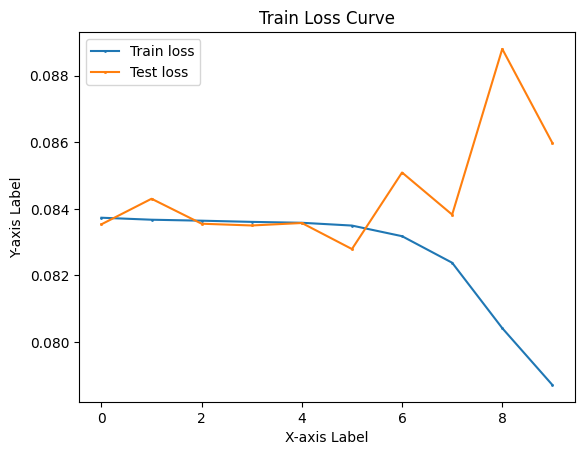

In [21]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(train_loss_list, label='Train loss', marker='o', markersize=1)
plt.plot(test_loss_list, label='Test loss', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Train Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

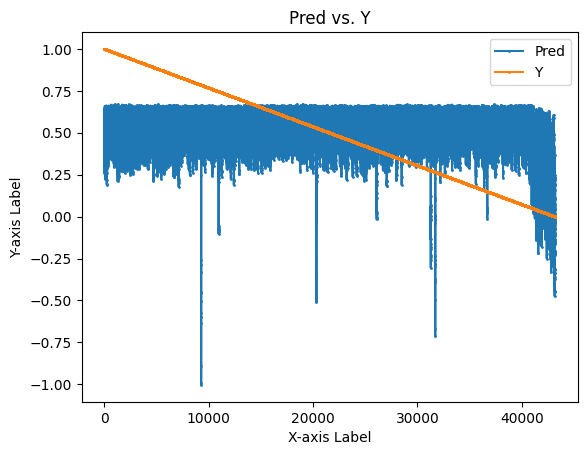

In [22]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(z, label='Pred', marker='o', markersize=1)
plt.plot(y, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Pred vs. Y')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

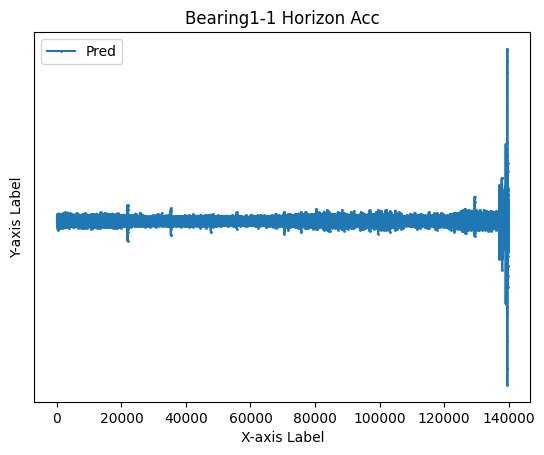

In [23]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(X_train[:, 0, 1], label='Pred', marker='o', markersize=1)
plt.yticks([])
# plt.plot(y, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Bearing1-1 Horizon Acc')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

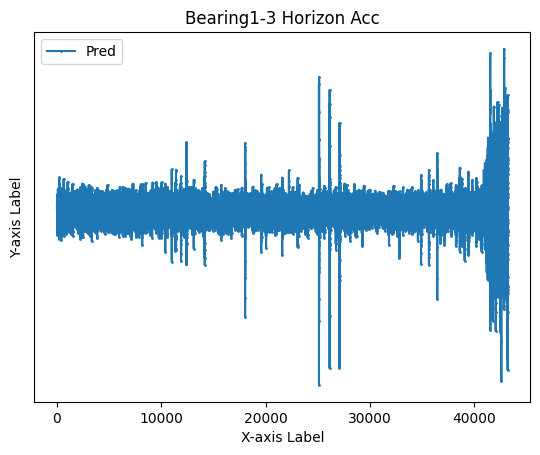

In [24]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(X_test[:, 0, 0], label='Pred', marker='o', markersize=1)
plt.yticks([])
# plt.plot(y, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label', )
plt.title('Bearing1-3 Horizon Acc')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

# Appendix

In [25]:
class test(nn.Module):
    def __init__(self):
        super(test, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
test_model = test()
m = nn.Sequential(nn.Linear(2,2), 
                  nn.ReLU(),
                 nn.Sequential(nn.Sigmoid(), nn.ReLU()))
print(m.children())
print(test_model.children())

<generator object Module.children at 0x7f4afc102450>
<generator object Module.children at 0x7f4afc102450>


In [26]:
print(type(prediction_list))

<class 'list'>


In [27]:
# model.children()
# model._moduless